In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy import stats
import shutil
import cv2
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn import preprocessing  
import optuna
from xgboost import XGBClassifier
from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage import io, color
from skimage.feature import local_binary_pattern
from skimage.util import img_as_ubyte
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

rng = np.random.RandomState(0)

### Extracting cases diagnosed with nevus and melanoma from tabular data

In [2]:
# df holds main table data, race_info holds race information (colour information)
df = pd.read_excel(r'D:\group_project\Skin_Data\skin_data.xlsx')
race_info = pd.read_csv(r'D:\group_project\Skin_Data\SupplementaryData.csv')
data = pd.concat([df, race_info['skin_type']], axis = 1)

# Images of nevus and melanoma cases were screened, discarding images with missing lesion locations
df_nm = data[(data['diagnosis'] == 'nevus') | (data['diagnosis'] == 'melanoma')].reset_index(drop = True)
df_nm = df_nm[~df_nm['anatom_site_general'].isna()]

# Delete unrelated columns
col = ['isic_id', 'age_approx', 'anatom_site_general', 'family_hx_mm', 'personal_hx_mm', 'sex', 'skin_type', 'diagnosis']
df_nm = df_nm[col]

In [3]:
# Medical history information converted to string representation and missing values filled with 'Unreported'
df_nm['family_hx_mm'][df_nm['family_hx_mm'].isna()] = 'Unreported'
df_nm['family_hx_mm'][df_nm['family_hx_mm'] == 0] = 'False'
df_nm['family_hx_mm'][df_nm['family_hx_mm'] == 1] = 'True'

df_nm['personal_hx_mm'][df_nm['personal_hx_mm'].isna()] = 'Unreported'
df_nm['personal_hx_mm'][df_nm['personal_hx_mm'] == 0] = 'False'
df_nm['personal_hx_mm'][df_nm['personal_hx_mm'] == 1] = 'True'

df_nm = df_nm.dropna()

In [4]:
# Replace the 3 least numbered lesion areas with 'Other'.
last_three_lesion_area = df_nm['anatom_site_general'].value_counts()[-3:].index.to_list()
df_nm['anatom_site_general'][df_nm['anatom_site_general'].isin(last_three_lesion_area)] = 'Other'

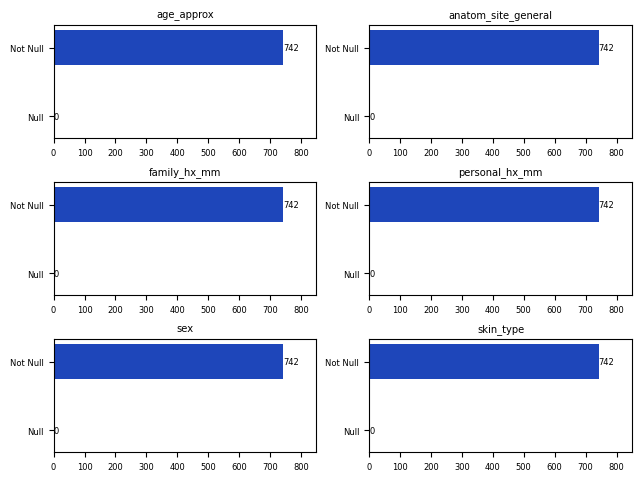

In [5]:
bar_width = 0.5 

for i, column in enumerate(['age_approx', 'anatom_site_general', 'family_hx_mm', 'personal_hx_mm', 'sex', 'skin_type']):
    # Counting the number of missing and non-missing values
    missing_count = df_nm[column].isnull().sum()
    non_missing_count = df_nm[column].notnull().sum()
    font_size = 6

    plt.rcParams.update({'font.size': font_size})
    plt.subplot(3, 2, i+1)
    plt.barh(['Null', 'Not Null'], 
             [missing_count, non_missing_count], 
             height=bar_width,
             color=[(0.1176, 0.2745, 0.7313)])
    
    # Add numerical labels to each bar
    for index, value in enumerate([missing_count, non_missing_count]):
        plt.text(value, index, str(value), ha='left', va='center')
    
    plt.title(f'{column}')
    plt.xlim(0, 850)
    plt.tight_layout()
plt.savefig(r'D:\Group_project\poster\counts_of_non.png', transparent = True)
plt.show()

In [6]:
# df_melanoma = df_nm[df_nm['diagnosis'] == 'melanoma']
# df_nm = pd.concat([df_nm, df_melanoma], axis = 0)

### Feature Engineering

In [7]:
def get_C_features(image_path):

    # Load the image
    image = cv2.imread(image_path)
    # Convert the image to HSV colour space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
     # Define the colour range
    lower_color = np.array([0, 50, 50])  # low threshold (red)
    upper_color = np.array([30, 255, 255])  # high threshold (yellow)
    # Create a mask based on the colour range
    mask = cv2.inRange(hsv_image, lower_color, upper_color)
    # Perform morphological operations on mask to remove noise
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Calculate the number of colours in the lesion
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_count = len(contours)
    # Calculate the colour rating based on the number of colours
    color_rating = min(color_count, 6)

    # Return the colour rating
    return color_rating

def C_feature_to_df(folder_path):
    # Get all the file names in the folder, stored in a list
    file_names = os.listdir(folder_path)
    for i in range(len(file_names)):
        # Get the path to each file
        image_path = os.path.join(folder_path, file_names[i])
        c = get_C_features(image_path)
        features = {'isic_id' : file_names[i][:-13], 'C' : c,}
        if (i == 0):
            df_features = pd.DataFrame(features, index = [i])
        else:
            new_df_features = pd.DataFrame(features, index = [i])
            df_features = pd.concat([df_features, new_df_features], ignore_index=True)
            
    return df_features

folder_path = r'D:\Group_project\Skin_Data\Original_Images_After_Process\Combined'
c_feature = C_feature_to_df(folder_path)
origin_c = pd.merge(c_feature, df_nm, left_on = 'isic_id', right_on = 'isic_id', how = 'inner')

In [8]:
# # When experimenting with different combinations of features, we need this cell
# origin_c.drop(columns = ['C'], inplace = True)

Anaother way to calculate LBP features:

In [9]:
# def get_lbp_features(image_path):
#     # LBP parameters
#     RADIUS = 1
#     N_POINTS = 8 * RADIUS
#     METHOD = 'uniform'
#     image = io.imread(image_path)
        
#     # If the image is not greyscale, convert to greyscale
#     if len(image.shape) > 2:
#         image = color.rgb2gray(image)
#     # Convert image to unsigned byte type
#     image = img_as_ubyte(image)  # Convert pixel value to integers 0-255
#     lbp = local_binary_pattern(image, N_POINTS, RADIUS, METHOD)

#     # Use mask to make the calculation of the lbp value focus only on the lesion area (simply and crudely discard the lbp value calculated for 
#       the area of the COMBINED image where the pixel point is 0)
#     mask_image = np.zeros(image.shape)
#     mask_lesion = (image >= 1)
#     mask_background = (image == 0)
#     mask_image[mask_lesion] = 1
#     mask_image[mask_background] = 0
#     lbp_mask = lbp * mask_image
    
#     # Calculate and return the histogram
#     (hist, _) = np.histogram(lbp_mask.ravel(), bins=np.arange(0, N_POINTS + 3), range=(0, N_POINTS + 2))
#     hist = hist.astype("float")
#     hist /= (hist.sum() + 1e-7)  # normalise histograms
#     def array_to_dict(arr):
#         result = {}
#         for i in range(1, len(arr)):
#             result['lbp_' + str(i - 1)] = arr[i]
#         return result
        
#     # Returns a dictionary
#     return array_to_dict(hist)

# def lbp_features_to_df(folder_path):
#      # Get all the file names in the folder, stored in a list
#     file_names = os.listdir(folder_path)
#     for i in range(len(file_names)):
#         # Get the path to each file
#         image_path = os.path.join(folder_path, file_names[i])
#         features = get_lbp_features(image_path)
#         features['isic_id'] = file_names[i][:-13]
#         if (i == 0):
#             df_features = pd.DataFrame(features, index = [i])
#         else:
#             new_df_features = pd.DataFrame(features, index = [i])
#             df_features = pd.concat([df_features, new_df_features], ignore_index=True)
            
#     return df_features

# folder_path = r'D:\Group_project\Skin_Data\Original_Images_After_Process\Combined'
# lbp_features = lbp_features_to_df(folder_path)
# origin_lbp_c = pd.merge(lbp_features, origin_c, left_on = 'isic_id', right_on = 'isic_id', how = 'inner')

In [10]:
def get_lbp_features(image_path):
    # LBP parameters
    RADIUS = 1
    N_POINTS = 8 * RADIUS
    METHOD = 'uniform'
    image = io.imread(image_path)
        
    # If the image is not greyscale, convert to greyscale
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    # Convert image to unsigned byte type
    image = img_as_ubyte(image)  # Convert pixel value to integers 0-255
    lbp = local_binary_pattern(image, N_POINTS, RADIUS, METHOD)

    # Use mask to make the calculation of the lbp value focus only on the lesion area (simply and crudely discard the lbp value calculated for 
    # the area of the COMBINED image where the pixel point is 0)
    mask_image = np.zeros(image.shape)
    mask_lesion = (image >= 1)
    mask_background = (image == 0)
    mask_image[mask_lesion] = 1
    mask_image[mask_background] = 0
    lbp_mask = lbp * mask_image
    
    # Calculate and return the histogram
    (hist, _) = np.histogram(lbp_mask.ravel(), bins=np.arange(0, N_POINTS + 3), range=(0, N_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # normalise histograms
    # Use a weight vector of the same size as the histogram
    weight_vector = np.arange(0, len(hist))
    mean = (weight_vector * hist).sum()  # calculate mean using weight vector
    std = np.sqrt(((weight_vector - mean) ** 2 * hist).sum())
    entropy = -np.sum(hist * np.log2(hist + 1e-7))
    # Create a dictionary using list derivation
    # lbp_dict = {"lbp_hist_" + str(i+1): hist[i] for i in range(len(hist))}
    lbp_dict = {}
    lbp_dict['lbp_mean'] = mean
    lbp_dict['lbp_std'] = std
    lbp_dict['lbp_entropy'] = entropy
    
    # Returns a dictionary
    return lbp_dict

def lbp_features_to_df(folder_path):
     # Get all the file names in the folder, stored in a list
    file_names = os.listdir(folder_path)
    for i in range(len(file_names)):
        # Get the path to each file
        image_path = os.path.join(folder_path, file_names[i])
        features = get_lbp_features(image_path)
        features['isic_id'] = file_names[i][:-13]
        if (i == 0):
            df_features = pd.DataFrame(features, index = [i])
        else:
            new_df_features = pd.DataFrame(features, index = [i])
            df_features = pd.concat([df_features, new_df_features], ignore_index=True)
            
    return df_features

folder_path = r'D:\Group_project\Skin_Data\Original_Images_After_Process\Combined'
lbp_features = lbp_features_to_df(folder_path)
origin_lbp_c = pd.merge(lbp_features, origin_c, left_on = 'isic_id', right_on = 'isic_id', how = 'inner')

In [11]:
# # When experimenting with different combinations of features, we need this cell
# origin_lbp_c = origin_c

In [12]:
# # Mapping of distribution
# sns.kdeplot(data=origin_lbp_glcm_c[origin_lbp_glcm_c['diagnosis'] == 0], x="lbp_2", label="nevus", shade=True)
# sns.kdeplot(data=origin_lbp_glcm_c[origin_lbp_glcm_c['diagnosis'] == 1], x="lbp_2", label="melanoma", shade=True)
# plt.legend()
# plt.show()

In [13]:
def get_glcm_features(image_path):
    # Load images
    image = io.imread(image_path)
    if len(image.shape) > 2:
        image_gray = color.rgb2gray(image)  # If colour image, convert to greyscale
    else:
        image_gray = image  # If it's already a grey scale image, use it directly
    # Normalise the image grey scale to 256 levels
    image_gray = (image_gray * 255).astype('uint8')
    # Compute the GLCM
    glcm = graycomatrix(image_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    # Extract GLCM texture features
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    feature_values = {feature: graycoprops(glcm, feature)[0, 0] for feature in features}
    # Returns a dictionary
    return feature_values

def glcm_fearues_to_df(folder_path):
    # Get all file names in the folder, stored in a list
    file_names = os.listdir(folder_path)
    for i in range(len(file_names)):
        # Get the path to each file
        image_path = os.path.join(folder_path, file_names[i])
        features = get_glcm_features(image_path)
        features['isic_id'] = file_names[i][:-4]
        if (i == 0):
            df_features = pd.DataFrame(features, index = [i])
        else:
            new_df_features = pd.DataFrame(features, index = [i])
            df_features = pd.concat([df_features, new_df_features], ignore_index=True)
            
    return df_features

folder_path = r'D:\Group_project\Skin_Data\Original_Images_After_Process\Original_Images'
glcm_features = glcm_fearues_to_df(folder_path)
origin_lbp_glcm_c = pd.merge(glcm_features, origin_lbp_c, left_on = 'isic_id', right_on = 'isic_id', how = 'inner')
col_isic_id = origin_lbp_glcm_c.pop('isic_id')
origin_lbp_glcm_c.insert(0, 'isic_id', col_isic_id)

In [14]:
# # When experimenting with different combinations of features, we need this cell
# origin_lbp_glcm_c = origin_lbp_c

In [15]:
def get_color_features(image_path):
    # Load images
    img = cv2.imread(image_path)
    # Convert to greyscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Use Canny edge detection
    edges = cv2.Canny(gray, 50, 150)
    # Use findContours to find edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return {'average_r':0, 'average_g':0, 'average_b':0, 'variance_r':0, 'variance_g':0, 
            'variance_b':0, 'moments_r': 0, 'moments_g':0, 'moments_b':0}
    else:
        # Find the largest contour
        max_contour = max(contours, key=cv2.contourArea)
        # Draw the edges on the original image
        cv2.drawContours(img, [max_contour], -1, (0, 0, 0), 2)
        # Get the rectangular boundaries of the region of interest
        x, y, w, h = cv2.boundingRect(max_contour)
        # Crop the region of interest
        interesting_region = img[y:y+h, x:x+w]
        # Extract non-zero part pixel values
        interesting_region = interesting_region.astype(float)
        interesting_region_r = interesting_region[:,:,0]
        interesting_region_g = interesting_region[:,:,1]
        interesting_region_b = interesting_region[:,:,2]
        interesting_region_r[interesting_region_r == 0] = np.nan 
        interesting_region_g[interesting_region_g == 0] = np.nan
        interesting_region_b[interesting_region_b == 0] = np.nan
        # Calculate the RGB mean
        average_r = np.nanmean(interesting_region_r)
        average_g = np.nanmean(interesting_region_g)
        average_b = np.nanmean(interesting_region_b)
        # Calculate RGB variance
        variance_r = np.nanvar(interesting_region_r)
        variance_g = np.nanvar(interesting_region_g)
        variance_b = np.nanvar(interesting_region_b)
        # Calculate RGB third order moments
        moments_r = np.nanmean((interesting_region_r - average_r) ** 3)
        moments_g = np.nanmean((interesting_region_g - average_g) ** 3)
        moments_b = np.nanmean((interesting_region_b - average_b) ** 3)
        
        return {'average_r':average_r, 'average_g':average_g, 'average_b':average_b, 'variance_r':variance_r, 'variance_g':variance_g, 
                'variance_b':variance_b, 'moments_r': moments_r, 'moments_g':moments_g, 'moments_b':moments_b}

def color_fearues_to_df(folder_path):
    # Get all the file names in the folder, stored in a list
    file_names = os.listdir(folder_path)
    for i in range(len(file_names)):
        # Get the path to each file
        image_path = os.path.join(folder_path, file_names[i])
        features = get_color_features(image_path)
        features['isic_id'] = file_names[i][:-13]
        if (i == 0):
            df_features = pd.DataFrame(features, index = [i])
        else:
            new_df_features = pd.DataFrame(features, index = [i])
            df_features = pd.concat([df_features, new_df_features], ignore_index=True)
            
    return df_features

folder_path = r'D:\Group_project\Skin_Data\Original_Images_After_Process\Combined'
color_features = color_fearues_to_df(folder_path)
origin_lbp_glcm_c_color = pd.merge(color_features, origin_lbp_glcm_c, left_on = 'isic_id', right_on = 'isic_id', how = 'inner')
col_isic_id = origin_lbp_glcm_c_color.pop('isic_id')
origin_lbp_glcm_c_color.insert(0, 'isic_id', col_isic_id)

In [16]:
# # When experimenting with different combinations of features, we need this cell
# origin_lbp_glcm_c_color = origin_lbp_glcm_c

In [110]:
# # When experimenting with different combinations of features, we need this cell
# # Go to table data
# cat_col = ['sex', 'age_approx', 'anatom_site_general', 'family_hx_mm' , 'personal_hx_mm', 'skin_type']
# origin_lbp_glcm_c_color.drop(columns = ['isic_id'], inplace = True)
# origin_lbp_glcm_c_color.drop(columns = cat_col, inplace = True)

# origin_lbp_glcm_c_color['diagnosis'][origin_lbp_glcm_c_color['diagnosis'] == 'melanoma'] = 1
# origin_lbp_glcm_c_color['diagnosis'][origin_lbp_glcm_c_color['diagnosis'] == 'nevus'] = 0 
# origin_lbp_glcm_c_color['diagnosis'] = origin_lbp_glcm_c_color['diagnosis'].astype(int)

# # Standardisation
# cat_col = ['sex', 'diagnosis', 'anatom_site_general', 'family_hx_mm' , 'personal_hx_mm', 'skin_type']
# num_col = np.setdiff1d(origin_lbp_glcm_c_color.columns.to_list(), cat_col).tolist()
# nummeric_col = origin_lbp_glcm_c_color[num_col]
# origin_lbp_glcm_c_color = origin_lbp_glcm_c_color.drop(columns = nummeric_col)
# zscore_scaler = preprocessing.StandardScaler()
# nummeric_col = zscore_scaler.fit_transform(nummeric_col)
# nummeric_col = pd.DataFrame(data = nummeric_col, columns = num_col)
# origin_lbp_glcm_c_color = pd.concat([origin_lbp_glcm_c_color, nummeric_col], axis = 1)
# origin_lbp_glcm_c_color

,diagnosis,ASM,C,average_b,average_g,average_r,contrast,correlation,dissimilarity,energy,homogeneity,lbp_entropy,lbp_mean,lbp_std,moments_b,moments_g,moments_r,variance_b,variance_g,variance_r
0,0,-0.239121,-0.489550,1.393445,2.165441,0.939397,-0.439148,-1.977308,-0.075899,-0.046006,-0.379712,-1.096473,-0.918914,-1.305381,-0.098537,-0.304906,-0.381521,-0.903441,-1.083634,-0.945878
1,1,-0.560929,-0.489550,-0.536871,0.094864,0.736578,0.314579,-0.471387,0.348371,-0.624162,-0.415686,-0.942149,-0.830005,-1.044963,0.127868,-0.331064,-0.565951,-0.326583,-0.664850,-0.465890
2,0,-0.536882,-0.489550,-0.639172,-0.881151,-0.374843,0.658685,0.556185,0.874591,-0.570458,-0.942334,0.478163,0.282798,0.685831,0.091718,0.321406,0.508074,-0.317335,0.156998,0.311154
3,1,-0.101574,-0.489550,1.401035,1.834300,3.076024,-0.773572,-2.823371,-0.529142,0.145976,0.062387,-1.289942,-1.015360,-1.815398,-0.118335,-0.345958,-0.406713,-0.748545,-0.866541,-0.826431
4,0,-0.515050,-0.489550,-0.834837,-0.485009,-0.198925,0.478758,-1.063420,0.977914,-0.523864,-1.051537,-1.006212,-0.870069,-1.160977,0.023757,0.005189,-0.064320,-0.545300,-0.470112,-0.361134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1,-0.388407,0.810982,-0.728777,-0.336088,0.880739,2.046636,0.561964,0.834481,-0.284022,-0.089209,1.004340,0.834729,1.103296,0.383325,0.010270,0.263054,0.122200,-0.516379,-0.051202
611,0,-0.381893,-0.489550,-0.370084,-0.367035,-0.396220,-0.466390,0.298662,-0.052158,-0.272795,-0.438569,-0.539810,-0.568385,-0.418343,-0.037459,-0.065409,0.549539,-0.626020,-0.477882,0.402022
612,0,-0.508690,2.761778,-1.460869,-1.089217,-0.159784,-0.640912,0.023410,-0.598098,-0.510643,0.406807,2.739947,3.771281,1.695429,-0.151225,-0.090432,0.113136,-0.235541,0.169261,0.854267
613,0,2.399524,-0.489550,0.670448,-0.078087,-1.289299,-0.995956,0.648267,-1.507776,2.244472,2.028347,-0.551690,-0.574761,-0.441388,-0.085195,-0.207830,-0.323874,-0.748523,-0.791389,-0.822018


In [13]:
# # When experimenting with different combinations of features, we need this cell
# # origin
# origin_lbp_glcm_c_color = origin_c

In [17]:
# Delete the isic_id column
origin_lbp_glcm_c_color.drop(columns = ['isic_id'], inplace = True)

cat_col = ['sex', 'diagnosis', 'anatom_site_general', 'family_hx_mm' , 'personal_hx_mm', 'skin_type']
num_col = np.setdiff1d(origin_lbp_glcm_c_color.columns.to_list(), cat_col).tolist()

# Convert gender and diagnosis from string type to 0 or 1
origin_lbp_glcm_c_color['sex'][origin_lbp_glcm_c_color['sex'] == 'male'] = 1
origin_lbp_glcm_c_color['sex'][origin_lbp_glcm_c_color['sex'] == 'female'] = 0 
origin_lbp_glcm_c_color['sex'] = origin_lbp_glcm_c_color['sex'].astype(int)

origin_lbp_glcm_c_color['diagnosis'][origin_lbp_glcm_c_color['diagnosis'] == 'melanoma'] = 1
origin_lbp_glcm_c_color['diagnosis'][origin_lbp_glcm_c_color['diagnosis'] == 'nevus'] = 0 
origin_lbp_glcm_c_color['diagnosis'] = origin_lbp_glcm_c_color['diagnosis'].astype(int)

# Extract typed independent variables for one-hot coding
category_col = origin_lbp_glcm_c_color[['anatom_site_general', 'family_hx_mm' , 'personal_hx_mm', 'skin_type']]
origin_lbp_glcm_c_color = origin_lbp_glcm_c_color.drop(columns = category_col)
feature_dummied = pd.get_dummies(category_col)
origin_lbp_glcm_c_color = pd.concat([origin_lbp_glcm_c_color, feature_dummied], axis = 1)

# Standardisation
nummeric_col = origin_lbp_glcm_c_color[num_col]
origin_lbp_glcm_c_color = origin_lbp_glcm_c_color.drop(columns = nummeric_col)
zscore_scaler = preprocessing.StandardScaler()
nummeric_col = zscore_scaler.fit_transform(nummeric_col)
nummeric_col = pd.DataFrame(data = nummeric_col, columns = num_col)
origin_lbp_glcm_c_color = pd.concat([origin_lbp_glcm_c_color, nummeric_col], axis = 1)
origin_lbp_glcm_c_color

,sex,diagnosis,anatom_site_general_Other,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_posterior torso,anatom_site_general_upper extremity,family_hx_mm_False,family_hx_mm_True,...,homogeneity,lbp_entropy,lbp_mean,lbp_std,moments_b,moments_g,moments_r,variance_b,variance_g,variance_r
0,0,0,0,1,0,0,0,0,1,0,...,-0.379712,-1.096473,-0.918914,-1.305381,-0.098537,-0.304906,-0.381521,-0.903441,-1.083634,-0.945878
1,1,1,0,0,0,0,1,0,1,0,...,-0.415686,-0.942149,-0.830005,-1.044963,0.127868,-0.331064,-0.565951,-0.326583,-0.664850,-0.465890
2,1,0,1,0,0,0,0,0,1,0,...,-0.942334,0.478163,0.282798,0.685831,0.091718,0.321406,0.508074,-0.317335,0.156998,0.311154
3,0,1,0,0,0,1,0,0,0,1,...,0.062387,-1.289942,-1.015360,-1.815398,-0.118335,-0.345958,-0.406713,-0.748545,-0.866541,-0.826431
4,1,0,0,0,0,0,0,1,1,0,...,-1.051537,-1.006212,-0.870069,-1.160977,0.023757,0.005189,-0.064320,-0.545300,-0.470112,-0.361134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1,1,0,0,0,0,1,0,1,0,...,-0.089209,1.004340,0.834729,1.103296,0.383325,0.010270,0.263054,0.122200,-0.516379,-0.051202
611,0,0,0,0,0,1,0,0,1,0,...,-0.438569,-0.539810,-0.568385,-0.418343,-0.037459,-0.065409,0.549539,-0.626020,-0.477882,0.402022
612,0,0,0,0,0,0,0,1,0,0,...,0.406807,2.739947,3.771281,1.695429,-0.151225,-0.090432,0.113136,-0.235541,0.169261,0.854267
613,0,0,0,0,0,0,1,0,1,0,...,2.028347,-0.551690,-0.574761,-0.441388,-0.085195,-0.207830,-0.323874,-0.748523,-0.791389,-0.822018


In [8]:
# # When experimenting with different combinations of features, we need this cell
# # origin
# origin_lbp_glcm_c_color_withid = origin_c

In [41]:
# origin_lbp_glcm_c_color = origin_lbp_glcm_c_color.drop(columns = ['isic_id'])

In [9]:
# # When experimenting with different combinations of features, we need this cell
# # origin
# clear_data = origin_lbp_glcm_c_color_withid.drop_duplicates().drop(columns = ['isic_id'])
# y_clear = clear_data["diagnosis"]
# X_clear = clear_data.drop("diagnosis", axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X_clear, y_clear,  test_size = 0.2, random_state = rng)

# clear_data['diagnosis'][clear_data['diagnosis'] == 'melanoma'] = 1
# clear_data['diagnosis'][clear_data['diagnosis'] == 'nevus'] = 0 
# clear_data['diagnosis'] = clear_data['diagnosis'].astype(int)

# clear_data['sex'][clear_data['sex'] == 'male'] = 1
# clear_data['sex'][clear_data['sex'] == 'female'] = 0 
# clear_data['sex'] = clear_data['sex'].astype(int)

# # 提取出分类型自变量进行one-hot编码
# category_col = clear_data[['anatom_site_general', 'family_hx_mm' , 'personal_hx_mm', 'skin_type']]
# clear_data = clear_data.drop(columns = category_col)
# feature_dummied = pd.get_dummies(category_col)
# clear_data = pd.concat([clear_data, feature_dummied], axis = 1)

# # 年龄标准化
# zscore_scaler = preprocessing.StandardScaler()
# clear_data['age_approx'] = zscore_scaler.fit_transform(clear_data[['age_approx']])

# y = clear_data["diagnosis"]
# X = clear_data.drop("diagnosis", axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Modeling

In [18]:
from sklearn.model_selection import train_test_split

# Split the training set into a training and test set 
y = origin_lbp_glcm_c_color["diagnosis"]
X = origin_lbp_glcm_c_color.drop("diagnosis", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state = 42)

In [19]:
# use optuna to tune the parameters of xgboost
def objective_xgb(trial):
    params = {
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "min_child_weight": trial.suggest_int("min_child_weight", 0.01, 1),
        "subsample": trial.suggest_loguniform("subsample", 0.1, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1),
        "eval_metric": trial.suggest_categorical("eval_metric", ["mlogloss"]),
    }

    # Fit the model
    xgb_clf = XGBClassifier(**params)

    xgb_clf.fit(X_train, y_train)

    # Predict and calculate log loss
    y_pred = xgb_clf.predict(X_test)

    return accuracy_score(y_test, y_pred)

study_xgboost = optuna.create_study(direction='maximize') 
study_xgboost.optimize(objective_xgb, n_trials = 20, show_progress_bar=True)

[I 2024-05-10 02:24:21,742] A new study created in memory with name: no-name-77415af5-755d-4ada-a92b-7e08ffa7dd84


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-10 02:24:25,063] Trial 0 finished with value: 0.8780487804878049 and parameters: {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.043662290653469306, 'n_estimators': 1236, 'min_child_weight': 1, 'subsample': 0.8045715450139146, 'colsample_bylevel': 0.5455087733657297, 'colsample_bytree': 0.2867103060116696, 'colsample_bynode': 0.6362115057729193, 'reg_alpha': 0.20943984085795012, 'reg_lambda': 0.16849988287157, 'eval_metric': 'mlogloss'}. Best is trial 0 with value: 0.8780487804878049.
[I 2024-05-10 02:24:26,122] Trial 1 finished with value: 0.8861788617886179 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.014242692135834545, 'n_estimators': 1021, 'min_child_weight': 1, 'subsample': 0.2964216014216112, 'colsample_bylevel': 0.4434288795768102, 'colsample_bytree': 0.42952314099544875, 'colsample_bynode': 0.5573372783601942, 'reg_alpha': 0.0909793947575476, 'reg_lambda': 0.08227882989539778, 'eval_metric': 'mlogloss'}. Best is trial 1 with valu

In [20]:
# xgb_clf = XGBClassifier(**study_xgboost.best_params, random_state=rng)
# xgb_clf.fit(X_train, y_train)
# # Predict and get the probabilities
# y_pred_best = xgb_clf.predict(X_test)

5 fold cross validation

In [21]:
origin_lbp_glcm_c_color = origin_lbp_glcm_c_color.drop_duplicates()
y_clear = origin_lbp_glcm_c_color["diagnosis"]
X_clear = origin_lbp_glcm_c_color.drop("diagnosis", axis=1)


In [22]:
# xgb_clf = XGBClassifier(**params, random_state=rng)
xgb_clf = XGBClassifier(**study_xgboost.best_params, random_state=rng)

In [23]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score
import numpy as np

# Define 5 fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=41)

# Accuracy calculated using cross validation
accuracy_scores = cross_val_score(xgb_clf, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)

# Calculate F1-score using cross validation
f1_scores = cross_val_score(xgb_clf, X, y, cv=kfold, scoring='f1', n_jobs=1)

# Calculate the average accuracy and its variance
mean_accuracy = np.mean(accuracy_scores)
variance_accuracy = np.var(accuracy_scores)

# Calculate the mean F1-score and its variance
mean_f1 = np.mean(f1_scores)
variance_f1 = np.var(f1_scores)

# Output results
print("Average accuracy:", mean_accuracy)
print("Accuracy variance:", variance_accuracy)
print("Average F1-score:", mean_f1)
print("F1-score variance:", variance_f1)

Average accuracy: 0.8780487804878048
Accuracy variance: 0.001163328706457796
Average F1-score: 0.7009026297085998
F1-score variance: 0.006081439487505101


In [24]:
xgb_clf.fit(X_train, y_train)
# Predict and get the probabilities
y_pred_best = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        91
           1       0.84      0.66      0.74        32

    accuracy                           0.88       123
   macro avg       0.86      0.81      0.83       123
weighted avg       0.88      0.88      0.87       123



In [28]:
# ok
xgb_clf_origin = xgb_clf
X_test_clf_origin = X_test
y_test_origin = y_test

In [54]:
# ok
xgb_clf_glcm = xgb_clf
X_test_clf_glcm = X_test
y_test_glcm = y_test

In [75]:
# ok
xgb_clf_glcm_lbp = xgb_clf
X_test_clf_glcm_lbp = X_test
y_test_glcm_lbp = y_test

In [101]:
# ok
xgb_clf_glcm_lbp_c = xgb_clf
X_test_clf_glcm_lbp_c = X_test
y_test_glcm_lbp_c = y_test

In [116]:
# ok
xgb_clf_glcm_lbp_c_color = xgb_clf
X_test_clf_glcm_lbp_c_color = X_test
y_test_glcm_lbp_c_color = y_test

In [215]:
# xgb_clf_origin_glcm = xgb_clf
# X_test_origin_glcm = X_test

In [133]:
# xgb_clf_origin_glcm_lbp = xgb_clf
# X_test_clf_origin_glcm_lbp = X_test

In [39]:
# xgb_clf_origin_glcm_lbp_color = xgb_clf
# X_test_clf_origin_glcm_lbp_color = X_test

In [267]:
# xgb_clf_origin_glcm_lbp_c = xgb_clf
# X_test_clf_origin_glcm_lbp_c = X_test

In [25]:
# ok
xgb_clf_origin_glcm_lbp_c_color = xgb_clf
X_test_clf_origin_glcm_lbp_c_color = X_test
y_test_origin_glcm_lbp_c_color = y_test

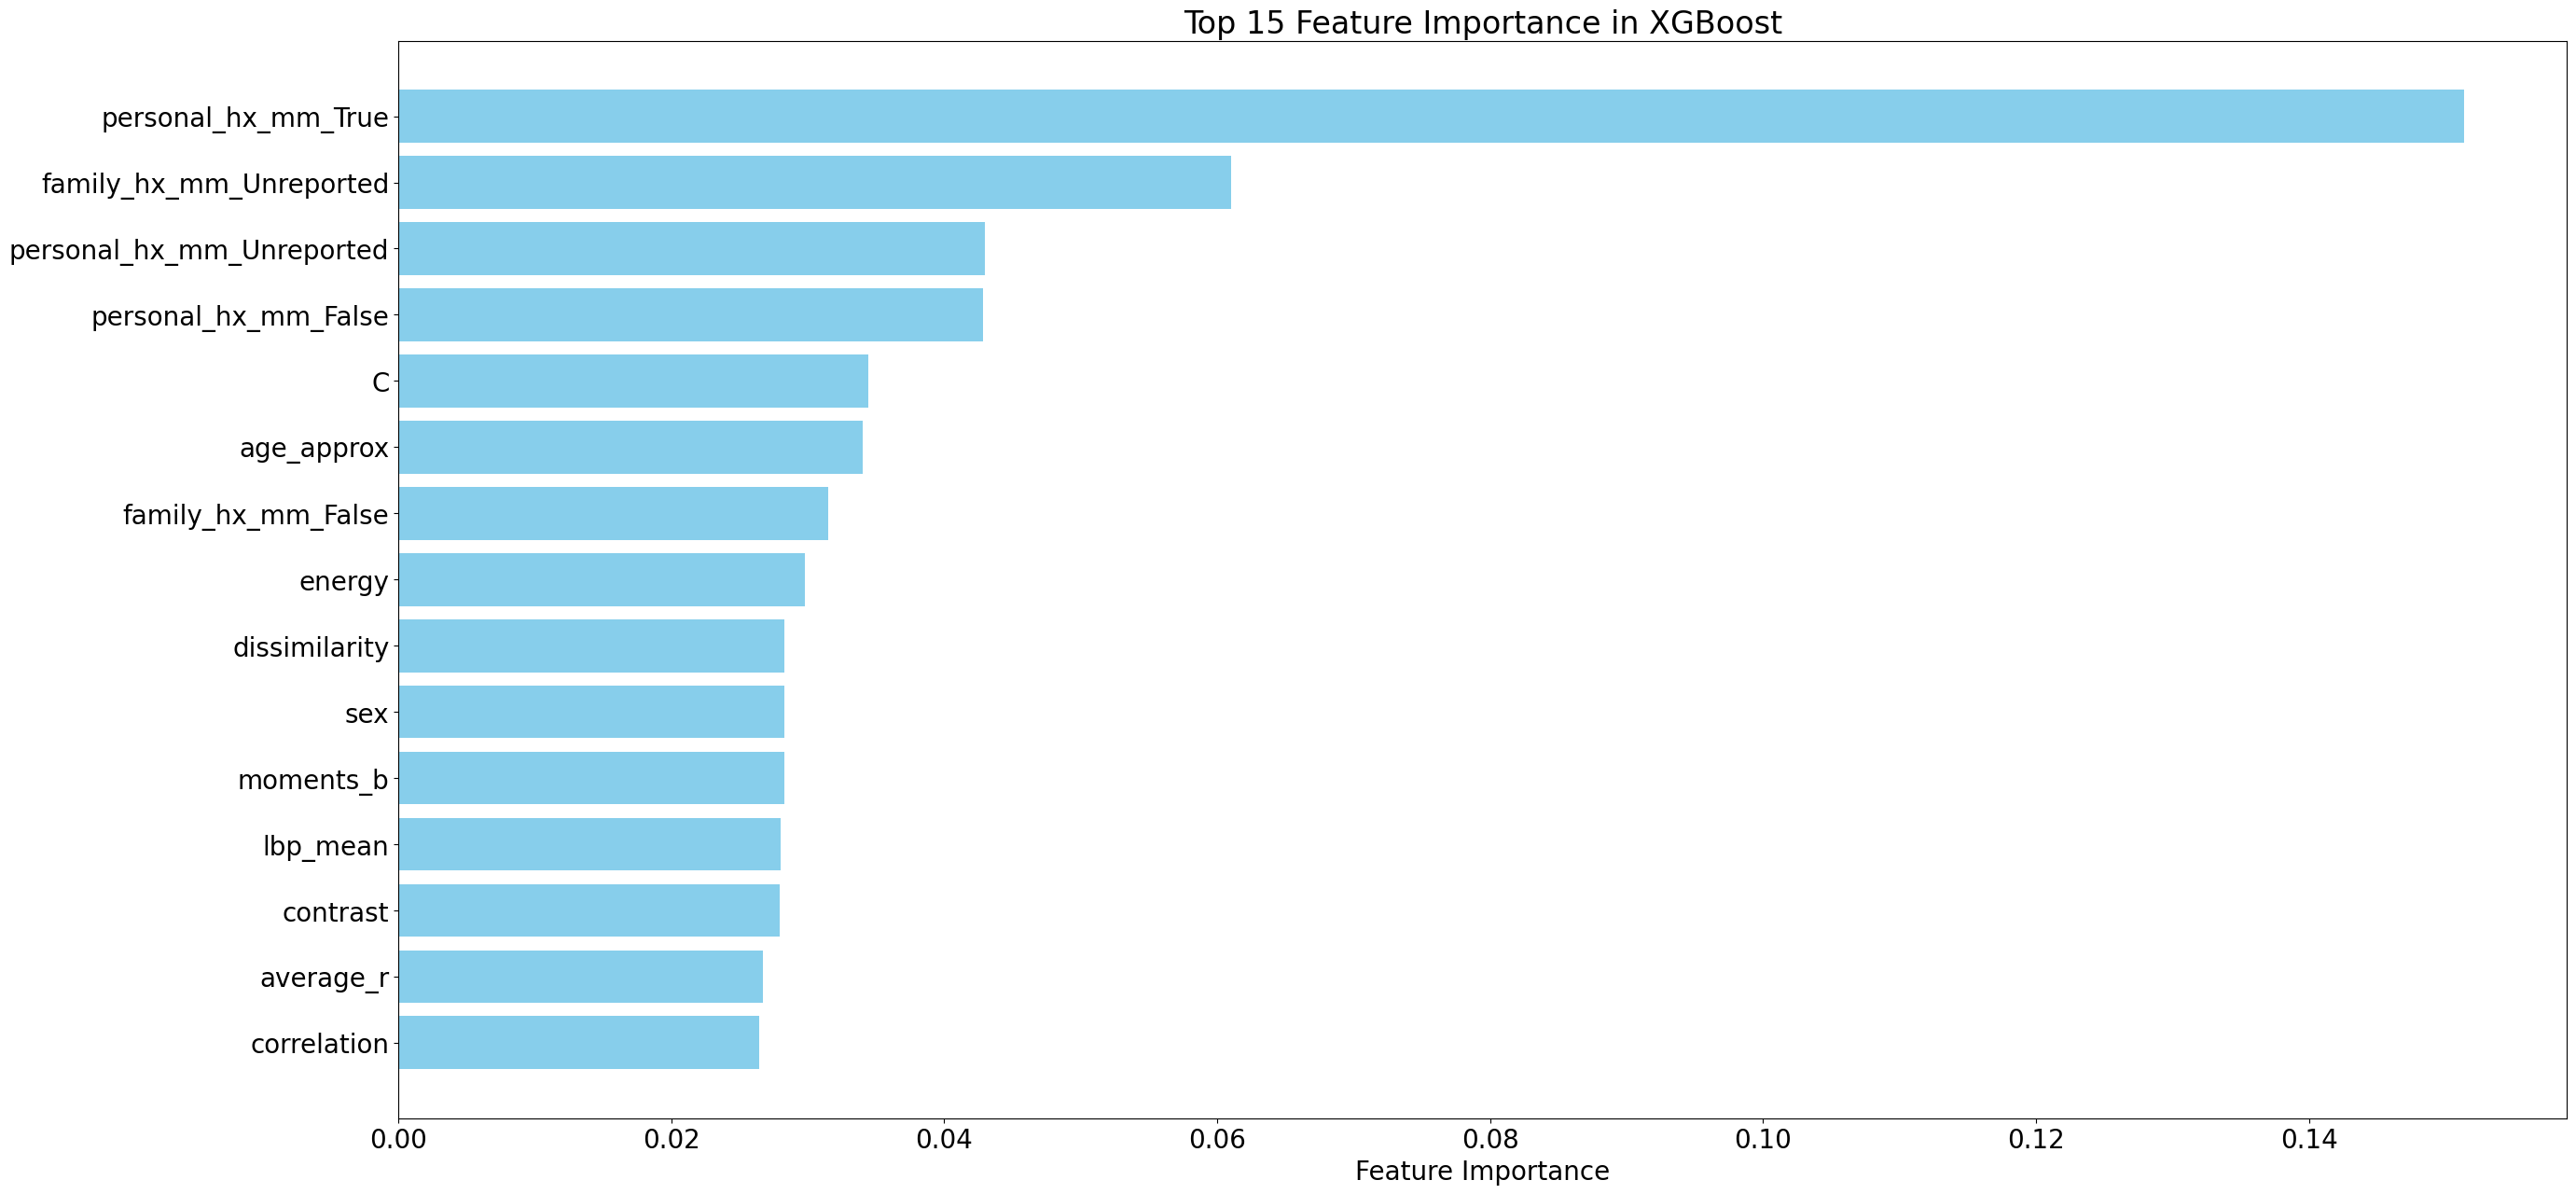

In [26]:
# Get feature significance
feature_importance = xgb_clf.feature_importances_
feature_names = X.columns  

# Find an index of the 15 most important features
top_indices = np.argsort(feature_importance)[::-1][:15]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]


# Mapping the significance of features
plt.figure(figsize=(30, 15))
# Set global font size
plt.rcParams.update({'font.size': 20})
plt.barh(np.arange(len(top_features)), top_importance, color='skyblue')
plt.yticks(np.arange(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance in XGBoost')
plt.gca().invert_yaxis()  # Presentation of feature importance in order from top to bottom
plt.savefig(r'D:\Group_project\poster\feature_importance_good.png', transparent=True)
plt.show()

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


Weight,Feature
0.0423 ± 0.0190,average_r
0.0423 ± 0.0315,age_approx
0.0390 ± 0.0315,personal_hx_mm_False
0.0374 ± 0.0335,personal_hx_mm_True
0.0374 ± 0.0130,contrast
0.0276 ± 0.0284,energy
0.0228 ± 0.0239,ASM
0.0163 ± 0.0103,correlation
0.0146 ± 0.0190,average_b
0.0130 ± 0.0130,homogeneity


In [ ]:
y_score_1 = xgb_clf_origin_glcm_lbp_c_color.predict_proba(X_test_clf_origin_glcm_lbp_c_color)[:, 1]
y_score_2 = xgb_clf_glcm_lbp.predict_proba(X_test_clf_glcm_lbp)[:, 1]
y_score_3 = xgb_clf_glcm.predict_proba(X_test_clf_glcm)[:, 1]
y_score_4 = xgb_clf_glcm_lbp_c_color.predict_proba(X_test_clf_glcm_lbp_c_color)[:, 1]
y_score_5 = xgb_clf_glcm_lbp_c.predict_proba(X_test_clf_glcm_lbp_c)[:, 1]
y_score_6 = xgb_clf_origin.predict_proba(X_test_clf_origin)[:, 1]


# Calculate the ROC curve  
fpr_1, tpr_1, _ = roc_curve(y_test_origin_glcm_lbp_c_color, y_score_1)  
roc_auc_1 = auc(fpr_1, tpr_1)  
fpr_2, tpr_2, _ = roc_curve(y_test_glcm_lbp, y_score_2)  
roc_auc_2 = auc(fpr_2, tpr_2)  
fpr_3, tpr_3, _ = roc_curve(y_test_glcm, y_score_3)  
roc_auc_3 = auc(fpr_3, tpr_3)  
fpr_4, tpr_4, _ = roc_curve(y_test_glcm_lbp_c_color, y_score_4)  
roc_auc_4 = auc(fpr_4, tpr_4) 
fpr_5, tpr_5, _ = roc_curve(y_test_glcm_lbp_c, y_score_5)  
roc_auc_5 = auc(fpr_5, tpr_5)  
fpr_6, tpr_6, _ = roc_curve(y_test_origin, y_score_6)  
roc_auc_6 = auc(fpr_6, tpr_6)  

# Plotting ROC curves  
plt.figure()  
plt.rcParams.update({'font.size': 10})
lw = 2  

plt.plot(fpr_3, tpr_3, color='b', lw=lw, label='GLCM (auc = %0.2f)' % roc_auc_3)
plt.plot(fpr_2, tpr_2, color='r', lw=lw, label='GLCM+LBP (auc = %0.2f)' % roc_auc_2)
plt.plot(fpr_5, tpr_5, color='m', lw=lw, label='GLCM+LBP+C (auc = %0.2f)' % roc_auc_5)
plt.plot(fpr_4, tpr_4, color='c', lw=lw, label='GLCM+LBP+C+Color (auc = %0.2f)' % roc_auc_4)
plt.plot(fpr_6, tpr_6, color='g', lw=lw, label='Tabular (auc = %0.2f)' % roc_auc_6) 
plt.plot(fpr_1, tpr_1, color='darkorange', lw=lw, label='Tabbular+GLCM+LBP+C+Color (auc = %0.2f)' % roc_auc_1)  


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('FPR')  
plt.ylabel('TPR')  
plt.title('ROC')  
plt.legend(loc="lower right")  
# plt.savefig(r'D:\Group_project\poster\ROC.png', transparent = True) 

### some of EDA

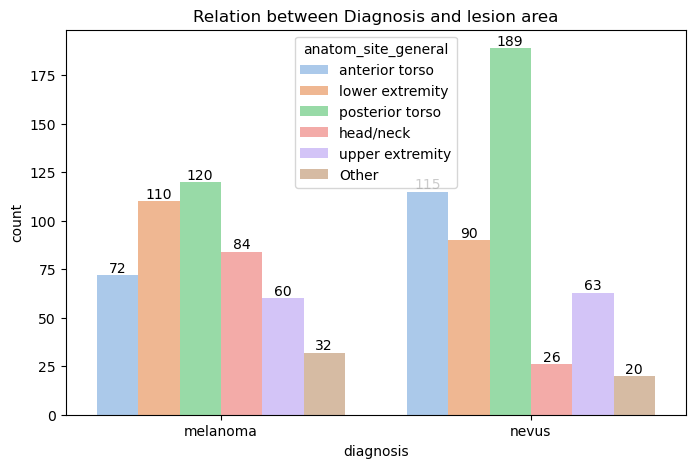

In [154]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(x='diagnosis', hue='anatom_site_general', data=df_nm, palette='pastel', ax=ax)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')

plt.title('Relation between Diagnosis and lesion area')
plt.show()

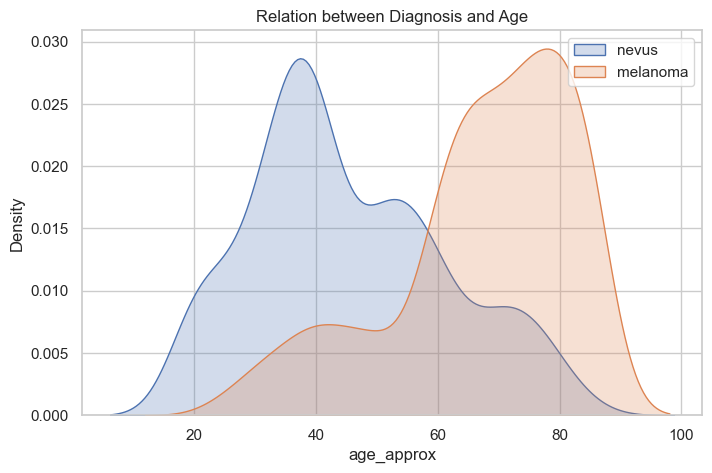

In [210]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Mapping of distribution
sns.kdeplot(data=df_nm[df_nm['diagnosis'] == 'nevus'], x="age_approx", label="nevus", shade=True)
sns.kdeplot(data=df_nm[df_nm['diagnosis'] == 'melanoma'], x="age_approx", label="melanoma", shade=True)
plt.title('Relation between Diagnosis and Age')
plt.legend()
plt.savefig(r'D:\Group_project\poster\age.png', transparent=True)
plt.show()

### Save all the images in Dullrazor_output that are nevus and melanoma to a new folder

In [ ]:
# Path to the folder to be searched
source_folder = r'D:\group_project\Skin_Data\Dullrazor_output\Dullrazor_output'

# Path to the folder where you want to save the matching file
destination_folder = r'D:\group_project\Skin_Data\Dullrazor_output\nevus_and_melanoma'

# List
search_list = df_nm['isic_id'].to_list()

# Iterate over files in a folder
for filename in os.listdir(source_folder):
    # Check if the filename contains any of the values in the list
    if any(value in filename for value in search_list):
        # Build the source and target file paths
        source_file = os.path.join(source_folder, filename)
        destination_file = os.path.join(destination_folder, filename)
        # Copy files to the destination folder
        shutil.copy(source_file, destination_file)

print("Matching files copied to destination folder.")

### Perform Gaussian blurring on the segmented result and merge the original image and the segmented image

In [ ]:
segmented_path = r'D:\Group_project\Skin_Data\Original_Images_After_Process\Contrast_and_Brightness\ISIC_9951988_Contrast_and_Brightness_res_retrain_v4.png'
segmented_image = cv2.imread(segmented_path, cv2.IMREAD_GRAYSCALE)

origin_image = cv2.imread(r'D:\Group_project\Skin_Data\Original_Images_After_Process\Original_Images\ISIC_9951988.JPG')

In [ ]:
# Apply Gaussian smoothing
smoothed_image = cv2.GaussianBlur(segmented_image, (9, 9), 3)
# Pixel value greater than 150 is considered lesion area, get the final segmentation result.
mask_lesion = (smoothed_image > 150)
mask_background = (smoothed_image <= 150)
smoothed_image[mask_lesion] = 255
smoothed_image[mask_background] = 0

plt.imshow(cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2RGB))

In [44]:
# input_path: path to the image
# output_path: path to the output result
input_path = r'D:\Group_project\Skin_Data\last_chance\Original_Images_and_Segmented_Out'
output_path = r'D:\Group_project\Skin_Data\last_chance\Combined'

# input_image_name: image file name (of the form: ISIC_2006754)
# suffix: suffix to be added to the split image
# save: if save is set to True, save the result image to the target; if save is set to False (the default setting), only two images are returned and not saved
def Smooth_and_Combine(input_image_name, suffix = '_Contrast_and_Brightness_res_retrain_v4', save = False, image_file_path = input_path, destinatin_path = output_path):
    origin_image_path = image_file_path + '/' + input_image_name + '.jpg'
    segmented_image_path = image_file_path + '/' + input_image_name + suffix +'.png'
    segmented_image = cv2.imread(segmented_image_path)
    origin_image = cv2.imread(origin_image_path)

    # Apply Gaussian smoothing
    smoothed_image = cv2.GaussianBlur(segmented_image, (9, 9), 3)

    # Pixel value greater than 200 is considered lesion area, get the final segmentation result.
    mask_lesion = (smoothed_image > 200)
    mask_background = (smoothed_image <= 200)
    smoothed_image[mask_lesion] = 255
    smoothed_image[mask_background] = 0

    # Display the original lesion region in the segmented image
    mask_255 = (smoothed_image == 255)
    smoothed_image[mask_255] = 1
    combined_image = origin_image * smoothed_image
    smoothed_image[mask_255] = 255
    
    if save:
        cv2.imwrite(destinatin_path + '/' + input_image_name + '_Combined.png', combined_image)
        #cv2.imwrite(destinatin_path + '/' + input_image_name + '_Smoothed.png', smoothed_image)
    else:
        return smoothed_image, combined_image

In [46]:
img_path = os.listdir(input_path)
file_name_list = []
for file in img_path:
    if '_Contrast_and_Brightness_res_retrain_v4' not in file:
        file_name_list.append(file[: -4])

In [49]:
for i in file_name_list:
    Smooth_and_Combine(i, suffix = '_Contrast_and_Brightness_res_retrain_v4', save = True)

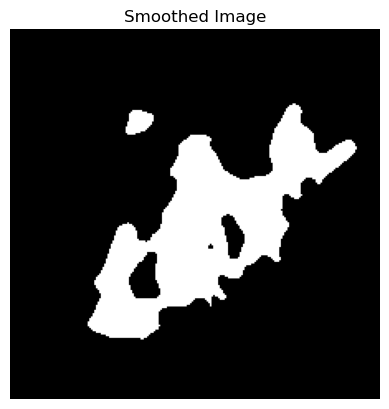

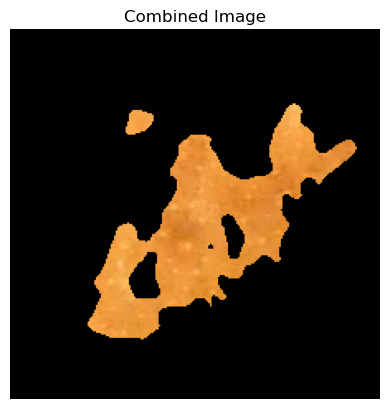

In [45]:
smoothed_image, combined_image = Smooth_and_Combine('ISIC_0202238', save = False)
# Display the smoothed image
plt.imshow(cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2RGB))
plt.title('Smoothed Image')
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.title('Combined Image')
plt.axis('off')
plt.show()